In [0]:
from pyspark.sql import SparkSession, DataFrame
import pyspark.sql.functions as f
from pyspark.sql.types import *
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.ml.feature import PCA, VectorAssembler, StringIndexer, Bucketizer, QuantileDiscretizer, MinMaxScaler,StandardScaler
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.linalg import DenseVector, VectorUDT, Vectors
from pyspark.sql.types import MapType, DoubleType, ArrayType, FloatType, ShortType
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce  # For Python 3.x
from itertools import chain, combinations
import os
from time import time
from pyspark.sql.window import Window

from typing import Dict
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import GBTRegressor, LinearRegression, RandomForestRegressor
from pyspark.ml.classification import GBTClassifier, OneVsRest
from pyspark.ml.feature import VectorIndexer, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder

In [0]:
your_unique_name="FinalProjectB" # Use this string to look for your app in the Spark UI
if your_unique_name=="noam_hw2":
    raise Exception("Please use your own name")

In [0]:
spark = SparkSession.builder.appName(your_unique_name).getOrCreate()

In [0]:
spark.conf.set("spark.sql.caseSensitive", "true")
prefix = "/mnt/lab94290/inputdata/part2/"
filelist = [ prefix + f'requestLog_C_92004{i}.log.tar_0.json' for i in range(0, 10)]
filelist2 = [ prefix + 'requestLog_C_920049.log.tar_0.json']
bids = spark.read.json(filelist)
test_bids = spark.read.json(filelist2)

In [0]:
print(f'Number of train bids: {bids.count()}, Number of test bids: {test_bids.count()}')

Number of train bids: 4010322, Number of test bids: 375740


# Auxiliary functions

In [0]:
def flatten_df(df):
    df = df.select([col(col_name).alias(col_name.replace('.', '_')) for col_name in flatten_aux(df.schema)])
    for c in df.columns:
        if isinstance(df.schema[c].dataType, ArrayType):
            df = df.withColumn(c, df[c].getItem(0))
    return df


def flatten_aux(schema, prefix=None):
    fields = []
    for field in schema.fields:
        name = prefix + '.' + field.name if prefix else field.name
        dtype = field.dataType
        if isinstance(dtype, ArrayType):
            dtype = dtype.elementType

        if isinstance(dtype, StructType) and field.name != 'unparseable':
            fields += flatten_aux(dtype, prefix=name)
        else:
            fields.append(name)

    return fields

def histogram(df, w_col, bins=100, xname=None, yname=None, subsample=0, title=None):
    vals = df.select(w_col).rdd.flatMap(lambda x: x).collect()
    sns.histplot(data=vals, bins=bins)
    plt.xlabel(w_col)
    plt.ylabel(yname)
    if title is not None:
        plt.title(title)
    plt.show()
    
def boxplot(df, w_col, xname=None, yname=None, subsample=0, title=None):
    vals = df.na.drop().select(w_col).rdd.flatMap(lambda x: x).collect()
    sns.boxplot(x=vals)
    plt.xlabel(w_col)
    plt.ylabel(yname)
    if title is not None:
        plt.title(title)
    plt.show()
    

def predict_and_save(model, df):
    dbutils.fs.rm("dbfs:/q1_315822239_316250877.csv",True)
    df = vectorize(df, None)
    pred = model.transform(df)
    pred = pred.filter(pred.prediction == 1.0).select('id').withColumnRenamed('id', 'anomaly')
    pred.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("dbfs:/FileStore/df/q1_315822239_316250877.csv")
    
    
def vectorize(df, predict_col, cat_features = ['location_countryCode', 'device_devicetype','imp_banner_pos','device_make','device_geo_type','device_connectiontype','device_dnt']):
    
    if predict_col: 
        df = df.withColumn("is_fake", f.when(df[predict_col] == True, 1.0).otherwise(0.0))
        df = df.drop(predict_col)

    
    features = [feat for feat in df.columns if feat not in  ["is_fake", "id"]]
    string_features = [feat for feat in cat_features]

    indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").setHandleInvalid("keep") for column in string_features]
    
    post_index_features = [feat+"_index" if feat in string_features else feat for feat in features]

    # create feature vector
    create_vectors = VectorAssembler(inputCols = post_index_features, outputCol='features').setHandleInvalid("keep")
    pipeline = Pipeline(stages=indexers + [create_vectors])
    
    return pipeline.fit(df).transform(df)

# Pre-processing

Flatten the DF

In [0]:
bids = flatten_df(bids)
test_bids = flatten_df(test_bids)
bids.printSchema()

root
 |-- app_bundle: string (nullable = true)
 |-- app_cat: string (nullable = true)
 |-- app_content_cat: string (nullable = true)
 |-- app_content_context: long (nullable = true)
 |-- app_content_embeddable: long (nullable = true)
 |-- app_content_episode: long (nullable = true)
 |-- app_content_language: string (nullable = true)
 |-- app_content_len: long (nullable = true)
 |-- app_content_livestream: long (nullable = true)
 |-- app_content_qagmediarating: long (nullable = true)
 |-- app_content_sourcerelationship: long (nullable = true)
 |-- app_content_url: string (nullable = true)
 |-- app_content_userrating: string (nullable = true)
 |-- app_content_videoquality: long (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_ext_apilevel: long (nullable = true)
 |-- app_ext_app_uptime: long (nullable = true)
 |-- app_ext_app_uptime_m: long (nullable = true)
 |-- app_ext_appstore_id: long (nullable = true)
 |-- app_ext_appstoreid: string (nullable = true)
 |-- app_ext

Feature selection: we'll chose the same feature as we choosen in previous works

In [0]:
selected_features = ['imp_bidfloor','location_countryCode', 'imp_banner_h', 'imp_banner_w', 'device_devicetype', 'imp_banner_pos', 'device_make', 'device_geo_type', 'device_connectiontype', 'device_dnt', 'fake']
df_bids = bids.select(*selected_features)
df_test_bids = test_bids.select(*selected_features + ['id'])

In [0]:
df_bids.show()

+--------------------+--------------------+------------+------------+-----------------+--------------+-----------+---------------+---------------------+----------+-----+
|        imp_bidfloor|location_countryCode|imp_banner_h|imp_banner_w|device_devicetype|imp_banner_pos|device_make|device_geo_type|device_connectiontype|device_dnt| fake|
+--------------------+--------------------+------------+------------+-----------------+--------------+-----------+---------------+---------------------+----------+-----+
|             3.59307|                 IRN|         250|         300|                4|             0|    Samsung|              2|                    3|         0|false|
|                null|                 sau|        null|        null|                4|             0|      apple|              1|                    6|      null|false|
|            1.837485|                 IRN|         250|         300|                4|             0|    Samsung|              2|                    

Let's check the distribuation of the target feature

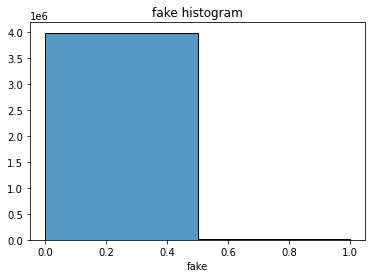

In [0]:
histogram(df_bids, 'fake',bins = 2, title='fake histogram')

We can see there a lot of not fake features

# Null values

In [0]:
df_bids.select(*[
    (
        f.count(f.when((f.isnan(c) | f.col(c).isNull()), c)) if t not in ("boolean")
        else f.count(f.when(f.col(c).isNull(), c))
    ).alias(c)
    for c, t in df_bids.dtypes 
]).show()

+------------+--------------------+------------+------------+-----------------+--------------+-----------+---------------+---------------------+----------+----+
|imp_bidfloor|location_countryCode|imp_banner_h|imp_banner_w|device_devicetype|imp_banner_pos|device_make|device_geo_type|device_connectiontype|device_dnt|fake|
+------------+--------------------+------------+------------+-----------------+--------------+-----------+---------------+---------------------+----------+----+
|      180331|                  18|      829676|      829676|                0|         67896|     351820|         771597|               181340|    823480|   0|
+------------+--------------------+------------+------------+-----------------+--------------+-----------+---------------+---------------------+----------+----+



In [0]:
test_bids.select(*[
    (
        f.count(f.when((f.isnan(c) | f.col(c).isNull()), c)) if t not in ("boolean")
        else f.count(f.when(f.col(c).isNull(), c))
    ).alias(c)
    for c, t in df_bids.dtypes 
]).show()

+------------+--------------------+------------+------------+-----------------+--------------+-----------+---------------+---------------------+----------+----+
|imp_bidfloor|location_countryCode|imp_banner_h|imp_banner_w|device_devicetype|imp_banner_pos|device_make|device_geo_type|device_connectiontype|device_dnt|fake|
+------------+--------------------+------------+------------+-----------------+--------------+-----------+---------------+---------------------+----------+----+
|       13365|                   3|       62237|       62237|                0|          4875|      34796|          74949|                17501|     61363|   0|
+------------+--------------------+------------+------------+-----------------+--------------+-----------+---------------+---------------------+----------+----+



We can see that many missing values are in the device columns, let's see if there's some correlcation between the missing values in those column to the target feature

In [0]:
df_fake_bids = df_bids.filter(df_bids.fake == 1)
df_fake_bids.select(*[
    (
        f.count(f.when((f.isnan(c) | f.col(c).isNull()), c)) if t not in ("boolean")
        else f.count(f.when(f.col(c).isNull(), c))
    ).alias(c)
    for c, t in df_fake_bids.dtypes 
]).show()

+------------+--------------------+------------+------------+-----------------+--------------+-----------+---------------+---------------------+----------+----+
|imp_bidfloor|location_countryCode|imp_banner_h|imp_banner_w|device_devicetype|imp_banner_pos|device_make|device_geo_type|device_connectiontype|device_dnt|fake|
+------------+--------------------+------------+------------+-----------------+--------------+-----------+---------------+---------------------+----------+----+
|           0|                   0|           0|           0|                0|             0|          0|          20203|                    0|         0|   0|
+------------+--------------------+------------+------------+-----------------+--------------+-----------+---------------+---------------------+----------+----+



We can see that most of the Null values appear only in the real bids, therefor we would not drop the null values.

## imp_bidfloor

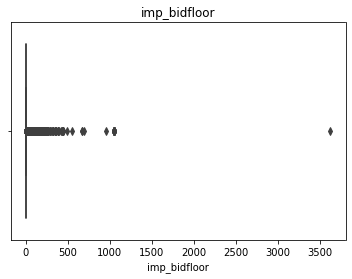

In [0]:
boxplot(df_bids, 'imp_bidfloor', title='imp_bidfloor')

In [0]:
df_bids.na.drop().approxQuantile('imp_bidfloor', [0.25, 0.75], 0)

Out[15]: [0.19920000000000002, 1.215]

Clearly we need tp filter the outliers

In [0]:
filterd_bids_df = df_bids.filter( ((df_bids.imp_bidfloor  > 0.1) & (df_bids.imp_bidfloor  < 4)) | (col("imp_bidfloor").isNull()))

## device_make

In [0]:
filterd_bids_df = filterd_bids_df.withColumn("filtered_make", f.lower(f.col('device_make')))
filterd_bids_df = filterd_bids_df.fillna(value='null', subset=['filtered_make'])
make_options = filterd_bids_df.select('filtered_make').distinct().collect()
top_device_makes = filterd_bids_df.select('filtered_make').groupby('filtered_make').count().orderBy(f.col('count').desc())
top_device_makes.show()

+-------------+-------+
|filtered_make|  count|
+-------------+-------+
|      samsung|1420065|
|        apple| 434244|
|       huawei| 248148|
|         null| 232827|
|       xiaomi| 176964|
|         oppo|  80080|
|         vivo|  64004|
|     motorola|  53458|
|      generic|  32889|
|           lg|  30882|
|       google|  28114|
|    allwinner|  26500|
|       realme|  22624|
|       lenovo|  22157|
|        nokia|  16334|
|         poco|  11658|
|        tecno|  10033|
|      oneplus|   9513|
|        redmi|   8022|
|        honor|   7995|
+-------------+-------+
only showing top 20 rows



In [0]:
top_device_makes.count()

Out[18]: 1178

We can't really use a statistic that gather from a group of bids that have the same device vendor and are less then 50 bids, therefor we'll reduce the dimensionality

In [0]:
filter_device_list = top_device_makes.filter((col('count') > 50)).select('filtered_make').rdd.flatMap(lambda x: x).collect()

In [0]:
reduce_make = {makes.__getitem__('filtered_make'): 'other' if makes.__getitem__('filtered_make') not in filter_device_list else makes.__getitem__('filtered_make') for makes in make_options}
filterd_bids_df = filterd_bids_df.replace(to_replace=reduce_make, subset=['filtered_make'])
filterd_bids_df = filterd_bids_df.replace(to_replace={'null': None}, subset=['filtered_make']).drop("device_make").withColumnRenamed("filtered_make","device_make")

## location_countryCode

In [0]:
filterd_bids_df = filterd_bids_df.withColumn("filtered_countryCode", f.lower(f.col('location_countryCode')))
filterd_bids_df = filterd_bids_df.fillna(value='null', subset=['filtered_countryCode'])
make_options = filterd_bids_df.select('filtered_countryCode').distinct().collect()
top_countrycode_makes = filterd_bids_df.select('filtered_countryCode').groupby('filtered_countryCode').count().orderBy(f.col('count').desc())
top_countrycode_makes.show()

+--------------------+------+
|filtered_countryCode| count|
+--------------------+------+
|                 irn|770683|
|                 are|478685|
|                 usa|318104|
|                 sau|312041|
|                 zaf|203909|
|                 bra|136869|
|                 qat| 92670|
|                 bhr| 71532|
|                 civ| 70208|
|                 ind| 69197|
|                 kwt| 66079|
|                 omn| 63374|
|                 ukr| 56176|
|                 swz| 44094|
|                 idn| 38471|
|                 rus| 38335|
|                 pak| 20905|
|                 mys| 16762|
|                 mex| 14366|
|                 srb| 12701|
+--------------------+------+
only showing top 20 rows



In [0]:
top_countrycode_makes.count()

Out[22]: 218

Again, we can't really use a statistic that gather from a group of bids that have the same country and are less then 50 bids, therefor we'll reduce the dimensionality

In [0]:
filter_country_list = top_countrycode_makes.filter((col('count') > 50)).select('filtered_countryCode').rdd.flatMap(lambda x: x).collect()

In [0]:
reduce_countrycode = {makes.__getitem__('filtered_countryCode'): 'other' if makes.__getitem__('filtered_countryCode') not in filter_country_list else makes.__getitem__('filtered_countryCode') for makes in make_options}
filterd_bids_df = filterd_bids_df.replace(to_replace=reduce_countrycode, subset=['filtered_countryCode'])
filterd_bids_df = filterd_bids_df.replace(to_replace={'null': None}, subset=['filtered_countryCode']).drop("location_countryCode").withColumnRenamed("filtered_countryCode","location_countryCode")

In [0]:
filterd_bids_df.show()

+-------------------+------------+------------+-----------------+--------------+---------------+---------------------+----------+-----+-----------+--------------------+
|       imp_bidfloor|imp_banner_h|imp_banner_w|device_devicetype|imp_banner_pos|device_geo_type|device_connectiontype|device_dnt| fake|device_make|location_countryCode|
+-------------------+------------+------------+-----------------+--------------+---------------+---------------------+----------+-----+-----------+--------------------+
|            3.59307|         250|         300|                4|             0|              2|                    3|         0|false|    samsung|                 irn|
|               null|        null|        null|                4|             0|              1|                    6|      null|false|      apple|                 sau|
|           1.837485|         250|         300|                4|             0|              2|                    3|         0|false|    samsung|        

## Now we apply the same dimensionality reduction to the testset

In [0]:
df_test_bids = df_test_bids.replace(to_replace=reduce_countrycode, subset=['location_countryCode'])
df_test_bids = df_test_bids.replace(to_replace={'null': None}, subset=['location_countryCode'])
df_test_bids = df_test_bids.replace(to_replace=reduce_make, subset=['device_make'])
df_test_bids = df_test_bids.replace(to_replace={'null': None}, subset=['device_make'])

# Question 1 + 2

We choose Gradient boosting for both question 1 and 2. Gradient Boosting is a machine learning technique used for classification and regression problems. It is an ensemble method that combines the predictions of multiple weak models to produce a more accurate and robust final prediction. The algorithm works by iteratively adding models to the ensemble, with each new model trying to correct the mistakes made by the previous models. The idea is to boost the overall performance by gradually improving the predictions through each iteration.

At each step, the gradient boosting algorithm uses the gradient of the loss function (e.g., mean squared error or cross-entropy) to identify the weaknesses of the current ensemble and to focus on improving the predictions in areas where they are weak. The algorithm continues this process until a pre-defined stopping criterion is reached, such as a maximum number of iterations or a minimum improvement in performance.

Gradient Boosting is considered to be one of the most powerful and widely used machine learning techniques due to its ability to model complex relationships and its ability to achieve high accuracy on a wide range of datasets. However, it can be computationally expensive and may suffer from overfitting if not properly tuned.

Now, we'll explain why we choose Gradient boosting:

* High Accuracy: Gradient Boosting has a reputation for achieving high accuracy on many datasets. This is due to its ability to model complex relationships and to iteratively improve the performance of the ensemble through each iteration.

* Robustness: Gradient Boosting is robust to many types of noise and outliers in the data. It also tends to work well when the data is highly unbalanced (just like in our case), meaning when one class has significantly more samples than the other.


* Feature Selection: Gradient Boosting can also be used for feature selection, which can help you to identify the most important features in your data. This is highly important in our case as we seen some "weird" phenomenon in the feature that we selected, for example with the missing values.  

* Good Handling of Non-Linear Relationships: Gradient Boosting has the ability to model complex, non-linear relationships between features and target variables that my appear in out data.

In [0]:
stream_df = vectorize(filterd_bids_df, "fake")

In [0]:
stream_df.show(10, False)

+------------------+------------+------------+-----------------+--------------+---------------+---------------------+----------+-----------+--------------------+-------+--------------------------+-----------------------+--------------------+-----------------+---------------------+---------------------------+----------------+-----------------------------------------------------------+
|imp_bidfloor      |imp_banner_h|imp_banner_w|device_devicetype|imp_banner_pos|device_geo_type|device_connectiontype|device_dnt|device_make|location_countryCode|is_fake|location_countryCode_index|device_devicetype_index|imp_banner_pos_index|device_make_index|device_geo_type_index|device_connectiontype_index|device_dnt_index|features                                                   |
+------------------+------------+------------+-----------------+--------------+---------------+---------------------+----------+-----------+--------------------+-------+--------------------------+-----------------------+------

In [0]:
(training, test) = stream_df.randomSplit([0.8, 0.2])

In [0]:
gbt = GBTClassifier(labelCol='is_fake',maxBins = 229, featuresCol='features')

evaluator = BinaryClassificationEvaluator(labelCol="is_fake")

paramGrid = ParamGridBuilder().addGrid(GBTClassifier.maxBins, [229, 500, 1000]).addGrid(GBTClassifier.maxDepth, [3, 5, 8]).build()

# 3-fold cross validation
crossval = CrossValidator(
    estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)


model = crossval.fit(training)

In [0]:
result = model.transform(test)

In [0]:
metrics = MulticlassMetrics(result.select(['is_fake', 'prediction']).rdd)

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [0]:
metrics.fMeasure(1.0, 2.0)

Out[33]: 0.9226166079186818

In [0]:
predict_and_save(model, df_test_bids)

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
<command-1192239699461687> in <cell line: 1>()
----> 1 predict_and_save(model, df_test_bids)

<command-4365755733466433> in predict_and_save(model, df)
     46     pred = model.transform(df)
     47     pred = pred.filter(pred.prediction == 1.0).select('id').withColumnRenamed('id', 'anomaly')
---> 48     pred.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("dbfs:/FileStore/df/q1_315822239_316250877.csv")
     49 
     50 

/databricks/spark/python/pyspark/instrumentation_utils.py in wrapper(*args, **kwargs)
     46             start = time.perf_counter()
     47             try:
---> 48                 res = func(*args, **kwargs)
     49                 logger.log_success(
     50                     module_name, class_name, function_name, time.perf_counter() - start, signature

/databricks/spark/pytho